In [59]:
import numpy as np
import pandas as pd
import nltk
nltk.download() 
import re
import matplotlib.pyplot as plt
import string
import seaborn as sns
%matplotlib inline  
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import 
from sklearn.naive_bayes import MultinomialNB
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.cross_validation import KFold, StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


### Dataset Loading

In [2]:
name = pd.read_csv("C:/Users/Murtaza/Desktop/SCU NOTES/all_name.csv",names = ['String'],header = 0)
name['label'] = 'Name'

In [3]:
location = pd.read_csv("C:/Users/Murtaza/Desktop/SCU NOTES/locations.csv",na_filter=False)
location = location.replace(['NULL'], '')
location['String'] = location['address'] + " " +  location['city'] + " " + location['state'] + " " + location['country']
location = location.drop(['address','city','state','country'], axis = 1)
location['label'] = 'Location'
def unique_loc(x):
    s=x.lower()
    slist = s.split()
    return " ".join(sorted(set(slist), key=slist.index)) 
location['String'] = location['String'].apply(lambda x: unique_loc(x))

In [4]:
title = pd.read_csv("C:/Users/Murtaza/Desktop/SCU NOTES/titles.csv",names = ['String'],header = 0)
title['label'] = 'Title'

In [5]:
# Concatenating the three datasets into a single dataset
nlt = pd.concat([name,location,title])
nlt = nlt.reset_index()

### Data Preprocessing

In [6]:
# Pre-Processing functions

# function to remove punctuation
def remove_punc(message):
    message = unicode(message, 'utf8').lower()
    message = re.sub(r'[^0-9a-zA-Z\s]', '', message)
    return message

# function to remove stopwords
def remove_stopwords(message):
    words = TextBlob(message).words
    stops = set(stopwords.words("english")) 
    return [w for w in words if not w in stops]

# function to detect if a string has a stopword
def is_stopwords(message):
    count = 0
    words = TextBlob(message).words
    stops = set(stopwords.words("english")) 
    for w in words:
        if w in stops:
            count+=1
    if count > 0:
        return 1
    else:
        return 0     

In [7]:
# Removing Punctuation
nlt['String'] = nlt.String.apply(lambda x: remove_punc(x))

#### One of the distinguishing feature between a title and name and address would be the presence of stopwords in a title. Let's find out if the hypothesis is true or not.

In [9]:
# Creating another column using the function defined above to check the presence of a stopword
nlt['stopwords'] = nlt.String.apply(lambda x: is_stopwords(x))

In [10]:
# Percentage of labels that have stopwords
a = nlt.groupby("label").size()
b =  nlt.groupby(["label","stopwords"]).size()
c = b.div(a, level = "label") * 100
c

label     stopwords
Location  0            94.536380
          1             5.463620
Name      0            90.858398
          1             9.141602
Title     0            60.850000
          1            39.150000
dtype: float64

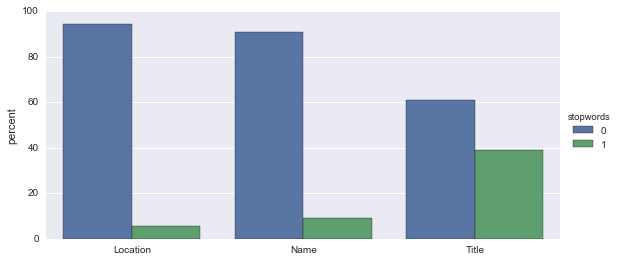

In [11]:
# Visualiation
c = c.reset_index()
c.columns.values[2] = "percent"
fg = sns.factorplot(x='label', y='percent', hue="stopwords",kind = 'bar',data=c,  size=4, aspect=2)
fg.set_xlabels('')

#### As we can see from the above graph, it clearly shows that Title have significamtly more % of stopwords as compared to Location and Name. Thus, Ill move forward without removing the stopwords.

#### Also, since location, title and name are all nouns, stemming and lemmatisation may not be needed.

### Train and Test Set

In [12]:
X_train, X_test, y_train, y_test = train_test_split(nlt['String'] , nlt['label'], test_size=0.20, random_state=42)

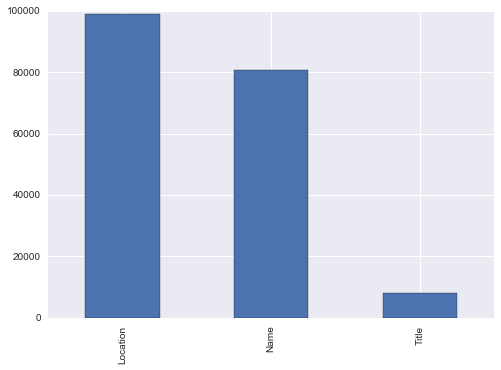

In [13]:
# Distribution of labels in the training set
y_train.value_counts().plot(kind='bar')

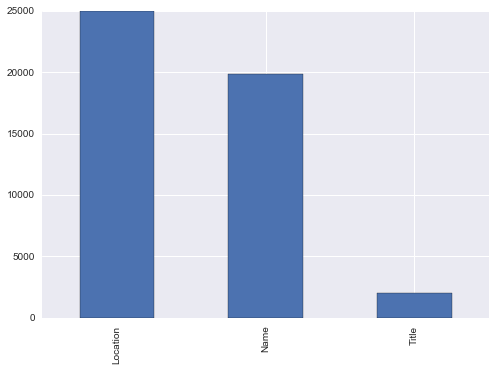

In [14]:
# Distribution of labels in the test set
y_test.value_counts().plot(kind='bar')

## Model Building

In [79]:
pipeline_nb = Pipeline([('vect',  CountVectorizer()),('tfidf', TfidfTransformer()),('clf_nb',  MultinomialNB())])
pipeline_sgdc = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf_sgdc', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, n_iter=5, random_state=42))])
pipeline_rf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf_rf', RandomForestClassifier(random_state = 42))])
pipeline_lr =  Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf_lr', LogisticRegression(random_state = 42))])

In [80]:
# 5-Fold Crossvalidation result for Naive Bayes Classifier
scores_nb = cross_val_score(pipeline_nb,  # steps to convert raw messages into models
                         X_train,  # training data
                         y_train,  # training labels
                         cv=5,  # split data randomly into 5 parts: 4 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=1,  # -1 = use all cores = faster
                         )
print scores_nb

[ 0.97989816  0.98117735  0.98053749  0.98003093  0.9794705 ]


In [81]:
print scores_nb.mean(), scores_nb.std()

0.980222883504 0.000586234638657


In [82]:
# 5-Fold Crossvalidation result for Random Forest
% time scores_rf = cross_val_score(pipeline_rf,X_train,y_train,cv=5,scoring='accuracy',n_jobs=1)
print scores_rf

Wall time: 2min 8s
[ 0.99410808  0.99528101  0.99496107  0.99496107  0.99434772]


In [83]:
print scores_rf.mean(), scores_rf.std()

0.994731791829 0.000434350980291


In [84]:
# 5-Fold Crossvalidation result for SGDC Classifier
% time scores_sgdc = cross_val_score(pipeline_sgdc, X_train,y_train,cv=5,scoring='accuracy',n_jobs=1)
print scores_sgdc

Wall time: 13.4 s
[ 0.94150737  0.93931961  0.94049269  0.94097259  0.94139761]


In [85]:
print scores_svm.mean(), scores_svm.std()

0.940737975313 0.000794234936237


In [86]:
% time scores_lr = cross_val_score(pipeline_lr,X_train,y_train,cv=5,scoring='accuracy',n_jobs=1)
print scores_lr

Wall time: 24.2 s
[ 0.99141539  0.99202837  0.99152181  0.99162845  0.9908817 ]


In [87]:
print scores_lr.mean(), scores_lr.std()

0.991495144856 0.000370264867841


#### From the above 4 models Logistic Regression and Random Forest seems to be the best performing model

### Model Tuning

In [88]:
# Let's find the optimal tuning parameter for count vectorizer using grid search with the logistic regression model
params = {
    'tfidf__use_idf': (True, False), # use tf-idf or not
    'vect__ngram_range': ((1, 1), (1, 2))  # unigrams or bigrams
}

grid = GridSearchCV(
    pipeline_lr,  # pipeline from above
    params,  # parameters to tune via cross validation
    refit=True,  # fit using all available data at the end, on the best found param combination
    n_jobs=1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(y_train, n_folds=5),  # what type of cross validation to use
)

In [89]:
%time lr_detector = grid.fit(X_train, y_train)
print lr_detector.grid_scores_

Wall time: 2min 19s
[mean: 0.99150, std: 0.00037, params: {'vect__ngram_range': (1, 1), 'tfidf__use_idf': True}, mean: 0.99111, std: 0.00042, params: {'vect__ngram_range': (1, 2), 'tfidf__use_idf': True}, mean: 0.99122, std: 0.00049, params: {'vect__ngram_range': (1, 1), 'tfidf__use_idf': False}, mean: 0.99097, std: 0.00044, params: {'vect__ngram_range': (1, 2), 'tfidf__use_idf': False}]


In [91]:
print lr_detector.best_params_
print lr_detector.best_score_

{'vect__ngram_range': (1, 1), 'tfidf__use_idf': True}
0.991495147702


#### So from above using Tf-idf with unigrams gives the best result.

In [92]:
# Let's find the optimal tuning parameter for random forest model
params_rf = {"clf_rf__n_estimators" : [5, 10, 20]}

grid_rf = GridSearchCV(
    pipeline_rf,  # pipeline from above
    params_rf,  # parameters to tune via cross validation
    refit=True,  # fit using all available data at the end, on the best found param combination
    n_jobs=1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(y_train, n_folds=5),  # what type of cross validation to use
)

In [93]:
%time rf_detector = grid_rf.fit(X_train, y_train)
print rf_detector.grid_scores_

Wall time: 8min 49s
[mean: 0.98179, std: 0.00618, params: {'clf_rf__n_estimators': 5}, mean: 0.99473, std: 0.00043, params: {'clf_rf__n_estimators': 10}, mean: 0.98758, std: 0.00374, params: {'clf_rf__n_estimators': 20}]


In [94]:
print rf_detector.best_params_
print rf_detector.best_score_

{'clf_rf__n_estimators': 10}
0.994731790551


In [95]:
# Let's find the optimal tuning parameter for SGDC model
params_sgdc ={'vect__ngram_range': [(1, 1), (1, 2)],'tfidf__use_idf': (True, False),'clf_sgdc__alpha': (1e-2, 1e-3)}

grid_sgdc = GridSearchCV(
    pipeline_sgdc,  # pipeline from above
    params_sgdc,  # parameters to tune via cross validation
    refit=True,  # fit using all available data at the end, on the best found param combination
    n_jobs=1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(y_train, n_folds=5),  # what type of cross validation to use
)

In [96]:
%time sgdc_detector = grid_sgdc.fit(X_train, y_train)
print sgdc_detector.grid_scores_

Wall time: 2min 30s
[mean: 0.84699, std: 0.00880, params: {'vect__ngram_range': (1, 1), 'tfidf__use_idf': True, 'clf_sgdc__alpha': 0.01}, mean: 0.88487, std: 0.07624, params: {'vect__ngram_range': (1, 2), 'tfidf__use_idf': True, 'clf_sgdc__alpha': 0.01}, mean: 0.82304, std: 0.00077, params: {'vect__ngram_range': (1, 1), 'tfidf__use_idf': False, 'clf_sgdc__alpha': 0.01}, mean: 0.82262, std: 0.00078, params: {'vect__ngram_range': (1, 2), 'tfidf__use_idf': False, 'clf_sgdc__alpha': 0.01}, mean: 0.94074, std: 0.00079, params: {'vect__ngram_range': (1, 1), 'tfidf__use_idf': True, 'clf_sgdc__alpha': 0.001}, mean: 0.91033, std: 0.00067, params: {'vect__ngram_range': (1, 2), 'tfidf__use_idf': True, 'clf_sgdc__alpha': 0.001}, mean: 0.95208, std: 0.00060, params: {'vect__ngram_range': (1, 1), 'tfidf__use_idf': False, 'clf_sgdc__alpha': 0.001}, mean: 0.93825, std: 0.00078, params: {'vect__ngram_range': (1, 2), 'tfidf__use_idf': False, 'clf_sgdc__alpha': 0.001}]


In [97]:
print sgdc_detector.best_params_
print sgdc_detector.best_score_

{'vect__ngram_range': (1, 1), 'tfidf__use_idf': False, 'clf_sgdc__alpha': 0.001}
0.952079556361


### Results on Test Set

In [98]:
# Result on Test Dataset using Naive Bayes Classifier
pipeline_nb = pipeline_nb.fit(X_train,y_train)
predicted = pipeline_nb.predict(X_test)
print confusion_matrix(y_test, predicted)
print classification_report(y_test, predicted)
print 'Accuracy Score:',accuracy_score(y_test, predicted)

[[24948     7     0]
 [  764 19102    15]
 [   37    56  1956]]
             precision    recall  f1-score   support

   Location       0.97      1.00      0.98     24955
       Name       1.00      0.96      0.98     19881
      Title       0.99      0.95      0.97      2049

avg / total       0.98      0.98      0.98     46885

Accuracy Score: 0.981251999573


In [99]:
# Result on Test Dataset using logistic regression model
predictions = lr_detector.predict(X_test)
print confusion_matrix(y_test, predictions)
print classification_report(y_test, predictions)
print 'Accuracy Score:',accuracy_score(y_test, predictions)

[[24839   116     0]
 [  126 19753     2]
 [    4   152  1893]]
             precision    recall  f1-score   support

   Location       0.99      1.00      1.00     24955
       Name       0.99      0.99      0.99     19881
      Title       1.00      0.92      0.96      2049

avg / total       0.99      0.99      0.99     46885

Accuracy Score: 0.991468486723


In [100]:
# Result on Test Dataset using Random Forest Clasifier
predictions = rf_detector.predict(X_test)
print confusion_matrix(y_test, predictions)
print classification_report(y_test, predictions)
print 'Accuracy Score:',accuracy_score(y_test, predictions)

[[24923    29     3]
 [   59 19769    53]
 [    3    75  1971]]
             precision    recall  f1-score   support

   Location       1.00      1.00      1.00     24955
       Name       0.99      0.99      0.99     19881
      Title       0.97      0.96      0.97      2049

avg / total       1.00      1.00      1.00     46885

Accuracy Score: 0.995265010131


In [101]:
# Result on Test Dataset using SGDC Classifier
#pipeline_svm = pipeline_svm.fit(X_train,y_train)
predicted = sgdc_detector.predict(X_test)
print confusion_matrix(y_test, predicted)
print classification_report(y_test, predicted)
print 'Accuracy Score:',accuracy_score(y_test, predicted)

[[23309  1645     1]
 [  115 19763     3]
 [    6   536  1507]]
             precision    recall  f1-score   support

   Location       0.99      0.93      0.96     24955
       Name       0.90      0.99      0.95     19881
      Title       1.00      0.74      0.85      2049

avg / total       0.95      0.95      0.95     46885

Accuracy Score: 0.950815825957
